# 1. Загрузка датасета

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

# Для воспроизводимости результатов
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Читаем CSV файл
df = pd.read_csv('/content/cybersequrity.csv')
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
display(df.head())

Размер датасета: (10000, 16)

Первые 5 строк:


,svcscan.fs_drivers,callbacks.ngeneric,psxview.not_in_eprocess_pool_false_avg,psxview.not_in_eprocess_pool,callbacks.nanonymous,psxview.not_in_session,psxview.not_in_pslist,psxview.not_in_pspcid_list,psxview.not_in_ethread_pool,psxview.not_in_csrss_handles,psxview.not_in_pslist_false_avg,psxview.not_in_pspcid_list_false_avg,psxview.not_in_deskthrd,psxview.not_in_ethread_pool_false_avg,psxview.not_in_session_false_avg,Class
0,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.044444,1
1,26,8,0.0,0,0,5,3,3,3,7,0.073171,0.073171,9,0.073171,0.121951,1
2,26,8,0.0,0,0,9,7,7,7,11,0.152174,0.152174,13,0.152174,0.195652,1
3,26,8,0.0,0,0,3,1,1,2,6,0.022222,0.022222,9,0.044444,0.066667,1
4,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.048780,0


# 2. Подготовка данных (1 балл)

In [2]:
# Разделяем признаки и целевую переменную
X = df.drop('Class', axis=1)
y = df['Class']

# Разделяем данные на train/val/test (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=RANDOM_STATE
)  # 0.25 * 0.8 = 0.2 от общего размера

# Стандартизация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Создаем тензоры PyTorch
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values)

X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.values)

X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values)

# Создаем загрузчики данных с batch_size=32
train_loader = DataLoader(
    list(zip(X_train_tensor, y_train_tensor)),
    batch_size=32,
    shuffle=True
)
val_loader = DataLoader(
    list(zip(X_val_tensor, y_val_tensor)),
    batch_size=32,
    shuffle=False
)
test_loader = DataLoader(
    list(zip(X_test_tensor, y_test_tensor)),
    batch_size=32,
    shuffle=False
)

print("Размеры выборок:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")


Размеры выборок:
Train: 6000
Validation: 2000
Test: 2000


# 3. Реализация базовой нейросетевой модели (2 балла)

In [3]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()

        # Архитектура сети:
        # - input_size -> 64 (первый слой, больше нейронов для извлечения признаков)
        # - 64 -> 32 (уменьшаем размерность)
        # - 32 -> 1 (выходной слой для бинарной классификации)
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),  # ReLU хорошо работает для глубоких сетей, не имеет проблемы затухающего градиента

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1),
            nn.Sigmoid()  # Sigmoid для получения вероятности в диапазоне [0,1]
        )

    def forward(self, x):
        return self.layers(x).squeeze()

# Создаем модель
input_size = X_train.shape[1]  # количество входных признаков
model = MLP(input_size)

# Переносим модель на GPU если доступно
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Используемое устройство: {device}")
print("\nСтруктура модели:")
print(model)

Используемое устройство: cuda

Структура модели:
MLP(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


# 4. Реализация цикла обучения и валидации (1 балл)

Epoch 0: train loss = 0.6761, val loss = 0.6600
Epoch 5: train loss = 0.5477, val loss = 0.5308
Epoch 10: train loss = 0.4927, val loss = 0.4796
Epoch 15: train loss = 0.4667, val loss = 0.4575
Epoch 20: train loss = 0.4578, val loss = 0.4433
Epoch 25: train loss = 0.4462, val loss = 0.4524
Epoch 30: train loss = 0.4379, val loss = 0.4261
Epoch 35: train loss = 0.4282, val loss = 0.4252
Epoch 40: train loss = 0.4224, val loss = 0.4103
Epoch 45: train loss = 0.4140, val loss = 0.4201


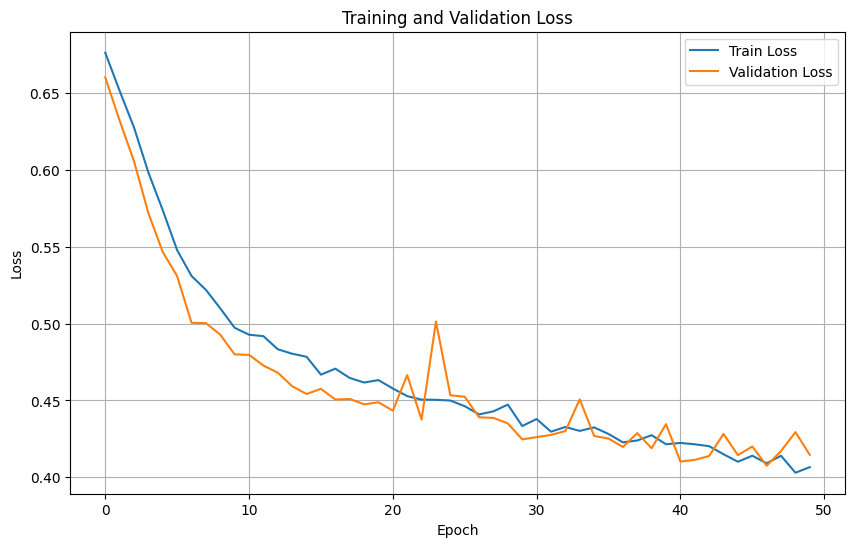

In [4]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    return running_loss / len(train_loader.dataset)

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)

    return running_loss / len(val_loader.dataset)

# Настройка обучения
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 50

# Списки для хранения значений функции потерь
train_losses = []
val_losses = []

# Цикл обучения
for epoch in range(n_epochs):
    # Обучение
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Валидация
    val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    if epoch % 5 == 0:
        print(f'Epoch {epoch}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}')

# Визуализация процесса обучения
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 5. Оценка качества модели (1 балл)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.71      0.77       981
         1.0       0.76      0.86      0.80      1019

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.78      2000
weighted avg       0.79      0.79      0.79      2000



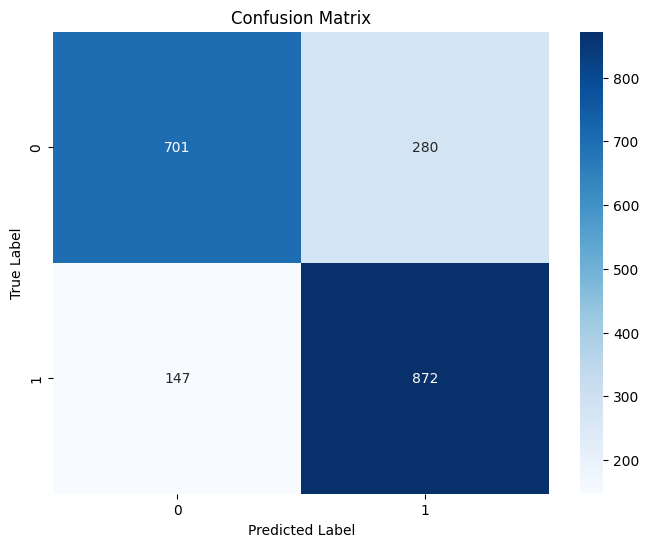

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions = (outputs >= 0.5).float().cpu()  # Порог 0.5 для бинарной классификации

            all_preds.extend(predictions.numpy())
            all_targets.extend(targets.numpy())

    return np.array(all_preds), np.array(all_targets)

# Получаем предсказания на тестовой выборке
y_pred, y_true = evaluate_model(model, test_loader, device)

# Выводим отчет о классификации
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Строим матрицу ошибок
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 6. Улучшение архитектуры модели (3 балла)

## 6.1 Эксперименты с архитектурой

In [6]:
class ImprovedMLP_V1(nn.Module):
    """
    Версия 1: BatchNorm после Linear слоя и перед активацией
    """
    def __init__(self, input_size, dropout_rate=0.2):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x).squeeze()

class ImprovedMLP_V2(nn.Module):
    """
    Версия 2: BatchNorm после активации
    """
    def __init__(self, input_size, dropout_rate=0.2):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_rate),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),

            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x).squeeze()

## 6.2 Функции для обучения и оценки

In [7]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    return running_loss / len(train_loader.dataset)

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
    return running_loss / len(val_loader.dataset)

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            preds = (outputs >= 0.5).float().cpu()
            all_preds.extend(preds.numpy())
            all_targets.extend(targets.numpy())
    return classification_report(all_targets, all_preds)

## 6.3 Проведение экспериментов


Эксперимент: dropout=0.1, batch_size=32, lr=0.001
Epoch 0: train_loss=0.6023, val_loss=0.6231
Epoch 10: train_loss=0.4750, val_loss=0.6158
Epoch 20: train_loss=0.4707, val_loss=0.5066
Early stopping at epoch 26


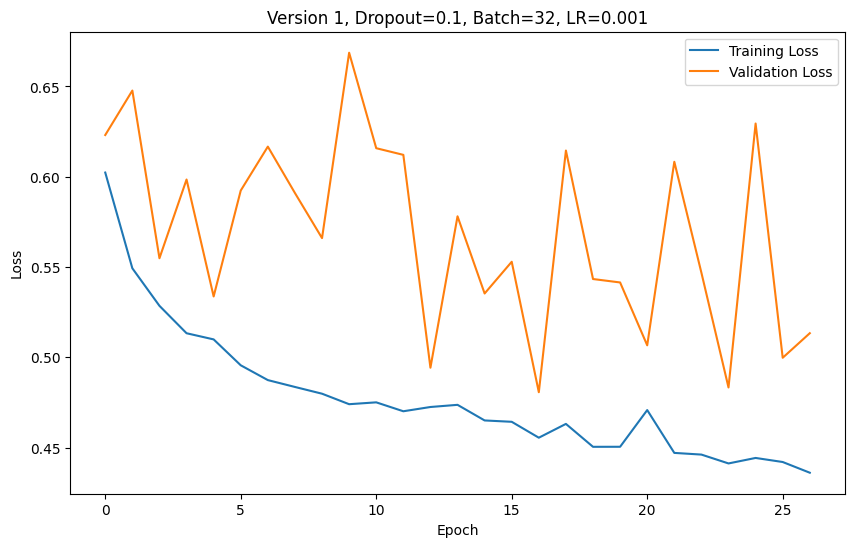

Epoch 0: train_loss=0.5637, val_loss=0.6536
Epoch 10: train_loss=0.4390, val_loss=0.4614
Epoch 20: train_loss=0.4252, val_loss=0.4809
Epoch 30: train_loss=0.4119, val_loss=0.4621
Early stopping at epoch 33


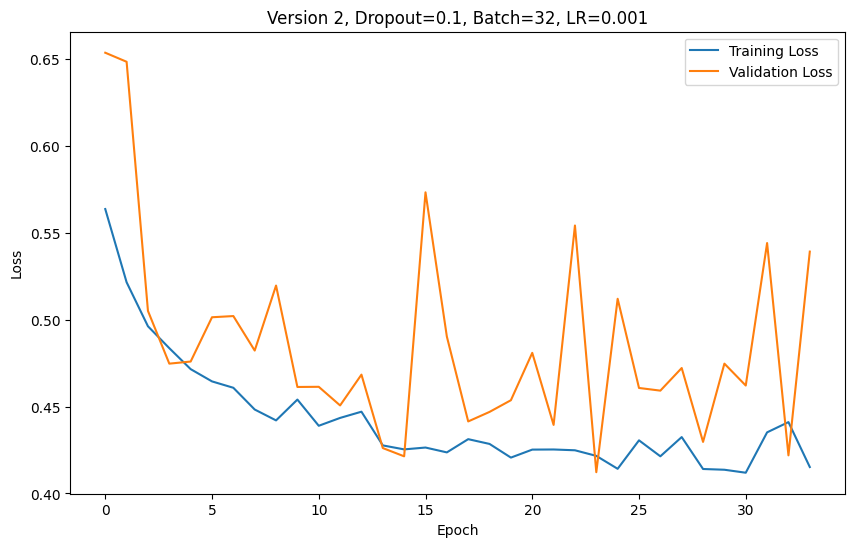


Эксперимент: dropout=0.1, batch_size=32, lr=0.0005
Epoch 0: train_loss=0.6166, val_loss=0.6546
Epoch 10: train_loss=0.4716, val_loss=0.6117
Epoch 20: train_loss=0.4499, val_loss=0.5634
Epoch 30: train_loss=0.4399, val_loss=0.6379
Early stopping at epoch 34


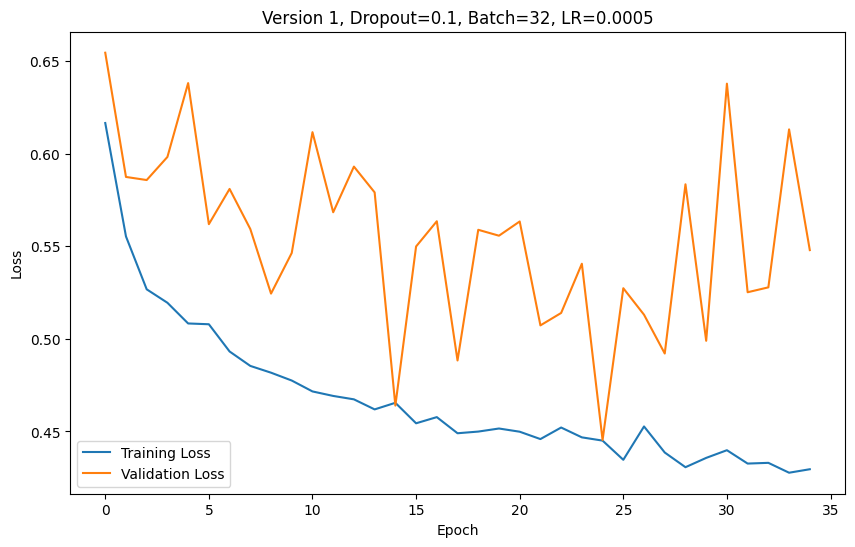

Epoch 0: train_loss=0.5984, val_loss=0.6270
Epoch 10: train_loss=0.4410, val_loss=0.4910
Epoch 20: train_loss=0.4227, val_loss=0.5018
Epoch 30: train_loss=0.4164, val_loss=0.4905
Epoch 40: train_loss=0.4038, val_loss=0.4836
Early stopping at epoch 43


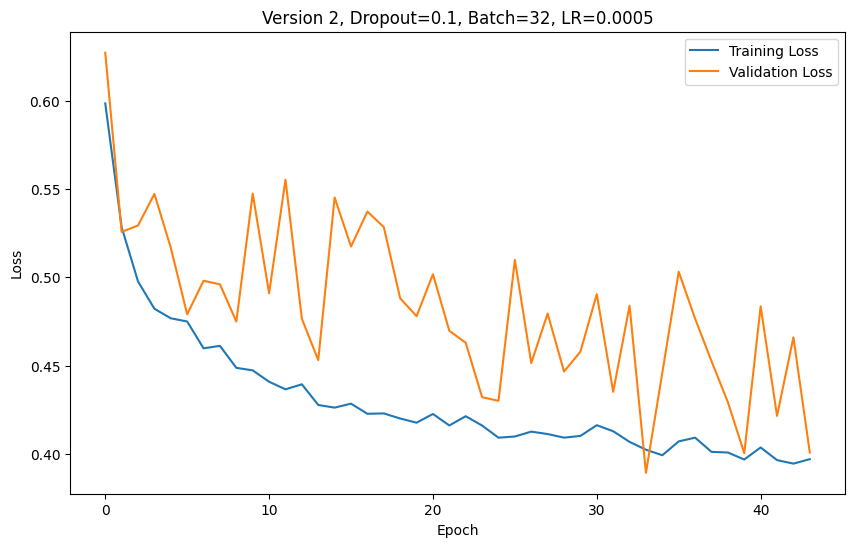


Эксперимент: dropout=0.1, batch_size=64, lr=0.001
Epoch 0: train_loss=0.6146, val_loss=0.6072
Epoch 10: train_loss=0.4465, val_loss=0.5109
Epoch 20: train_loss=0.4222, val_loss=0.4332
Early stopping at epoch 30


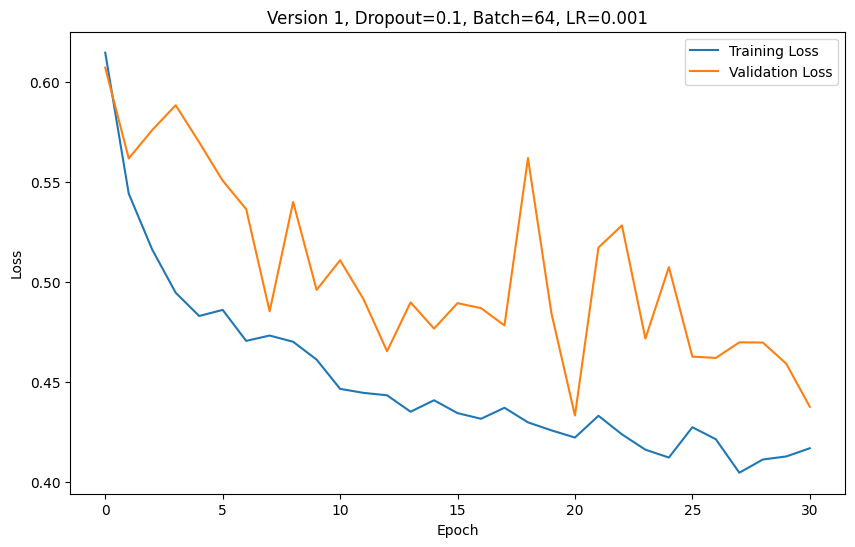

Epoch 0: train_loss=0.5887, val_loss=0.6152
Epoch 10: train_loss=0.4382, val_loss=0.4838
Epoch 20: train_loss=0.4039, val_loss=0.4072
Epoch 30: train_loss=0.3879, val_loss=0.4274
Early stopping at epoch 37


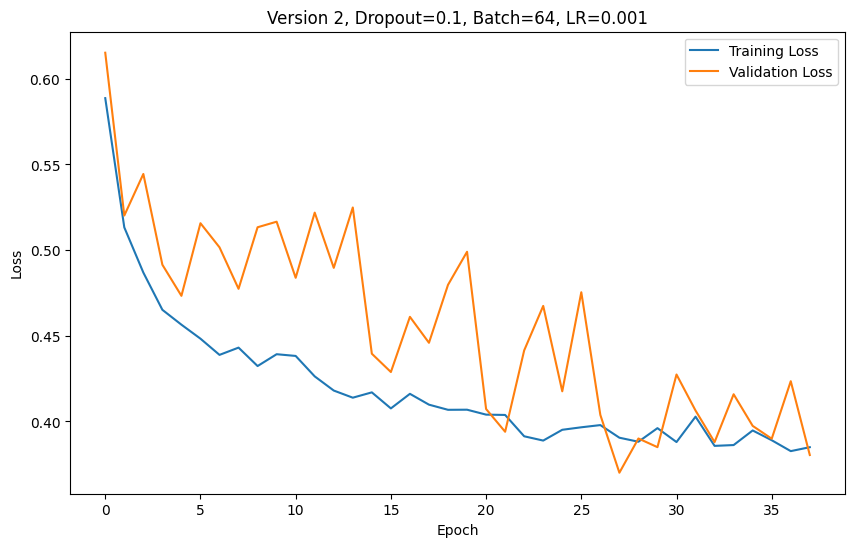


Эксперимент: dropout=0.1, batch_size=64, lr=0.0005
Epoch 0: train_loss=0.6319, val_loss=0.6233
Epoch 10: train_loss=0.4613, val_loss=0.4725
Early stopping at epoch 20


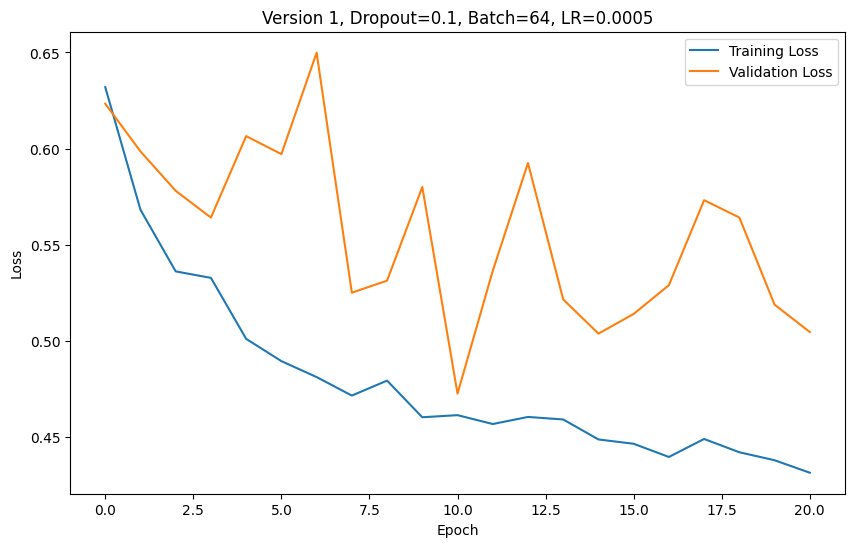

Epoch 0: train_loss=0.6142, val_loss=0.5949
Epoch 10: train_loss=0.4284, val_loss=0.5716
Epoch 20: train_loss=0.4096, val_loss=0.4952
Epoch 30: train_loss=0.3914, val_loss=0.4885
Epoch 40: train_loss=0.3789, val_loss=0.4137
Early stopping at epoch 50


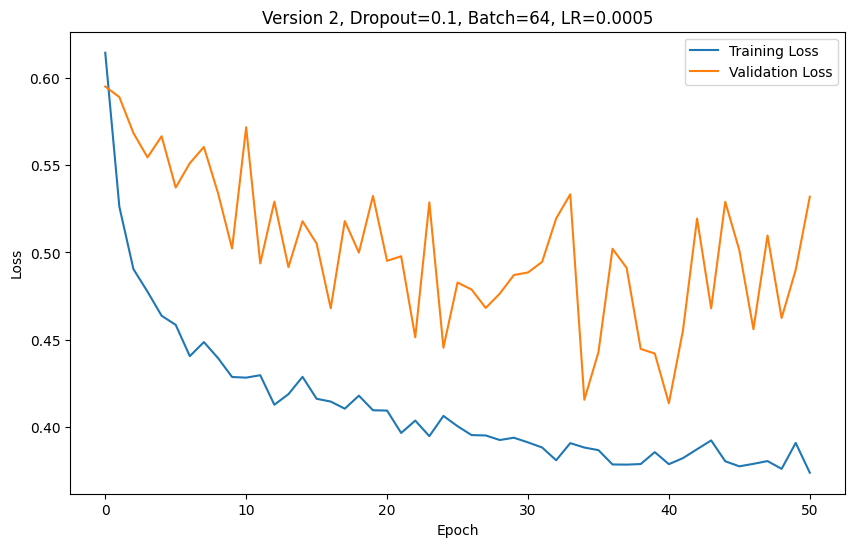


Эксперимент: dropout=0.1, batch_size=128, lr=0.001
Epoch 0: train_loss=0.6529, val_loss=0.6263
Epoch 10: train_loss=0.4557, val_loss=0.5336
Epoch 20: train_loss=0.4185, val_loss=0.4434
Epoch 30: train_loss=0.3972, val_loss=0.4710
Epoch 40: train_loss=0.3928, val_loss=0.4185
Epoch 50: train_loss=0.3979, val_loss=0.3745
Early stopping at epoch 60


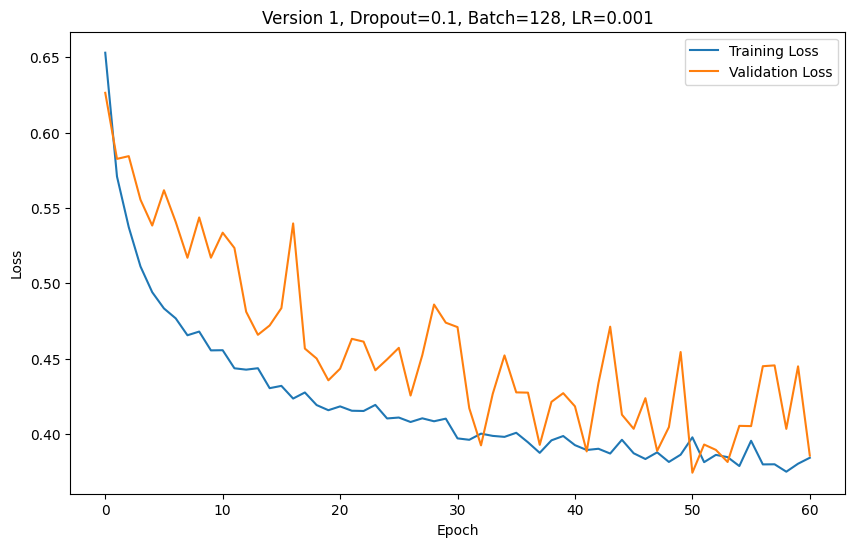

Epoch 0: train_loss=0.5985, val_loss=0.5949
Epoch 10: train_loss=0.4167, val_loss=0.4829
Epoch 20: train_loss=0.3962, val_loss=0.4077
Epoch 30: train_loss=0.3809, val_loss=0.3948
Epoch 40: train_loss=0.3652, val_loss=0.3776
Epoch 50: train_loss=0.3638, val_loss=0.3682
Epoch 60: train_loss=0.3573, val_loss=0.3609
Epoch 70: train_loss=0.3574, val_loss=0.3529
Epoch 80: train_loss=0.3464, val_loss=0.3495
Epoch 90: train_loss=0.3488, val_loss=0.3517


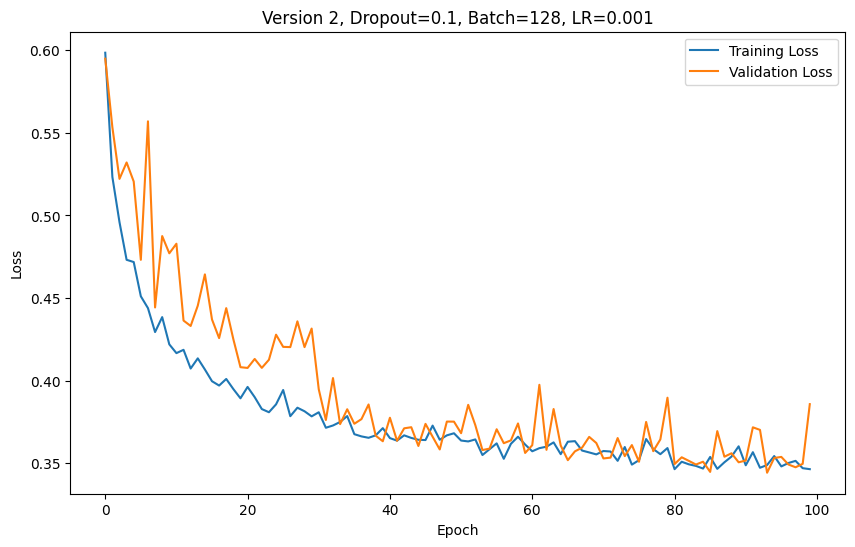


Эксперимент: dropout=0.1, batch_size=128, lr=0.0005
Epoch 0: train_loss=0.6611, val_loss=0.6393
Epoch 10: train_loss=0.4690, val_loss=0.4925
Epoch 20: train_loss=0.4306, val_loss=0.5149
Epoch 30: train_loss=0.4054, val_loss=0.4547
Epoch 40: train_loss=0.3945, val_loss=0.4293
Epoch 50: train_loss=0.3795, val_loss=0.4274
Early stopping at epoch 51


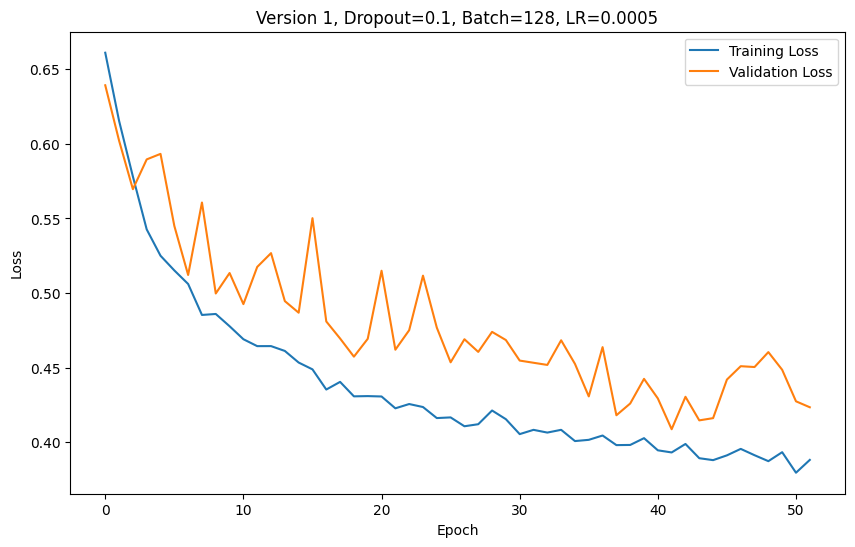

Epoch 0: train_loss=0.6222, val_loss=0.6192
Epoch 10: train_loss=0.4245, val_loss=0.4539
Epoch 20: train_loss=0.3958, val_loss=0.4447
Epoch 30: train_loss=0.3926, val_loss=0.4160
Epoch 40: train_loss=0.3747, val_loss=0.3657
Epoch 50: train_loss=0.3752, val_loss=0.3760
Early stopping at epoch 58


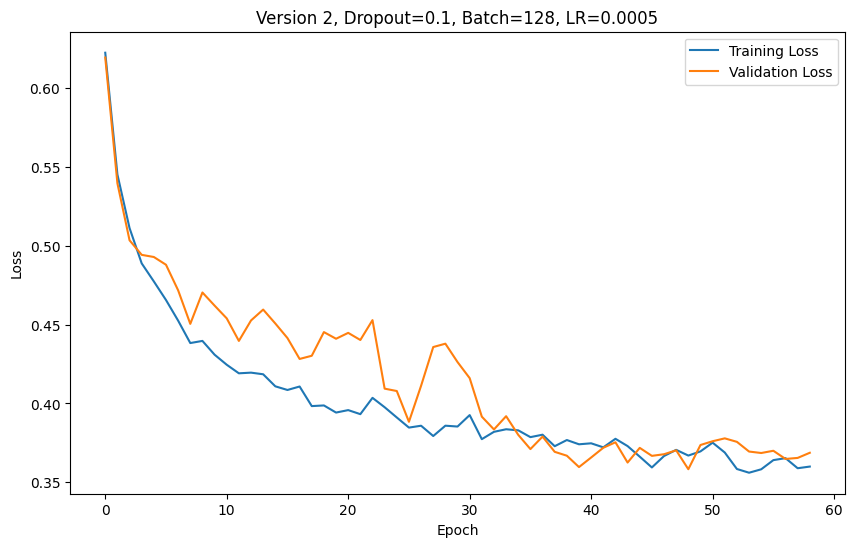


Эксперимент: dropout=0.2, batch_size=32, lr=0.001
Epoch 0: train_loss=0.6266, val_loss=0.6094
Epoch 10: train_loss=0.4920, val_loss=0.5803
Epoch 20: train_loss=0.4635, val_loss=0.5413
Early stopping at epoch 26


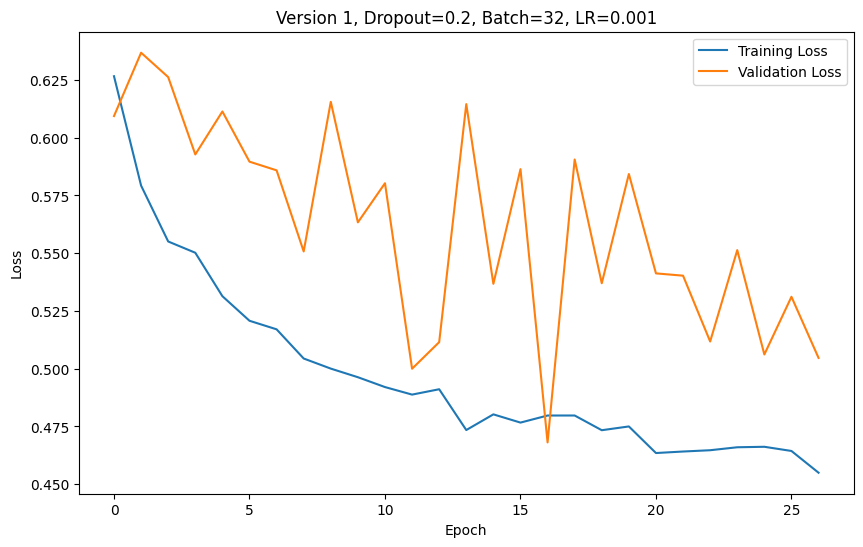

Epoch 0: train_loss=0.5980, val_loss=0.6076
Epoch 10: train_loss=0.4626, val_loss=0.4892
Epoch 20: train_loss=0.4412, val_loss=0.5062
Epoch 30: train_loss=0.4309, val_loss=0.4275
Early stopping at epoch 32


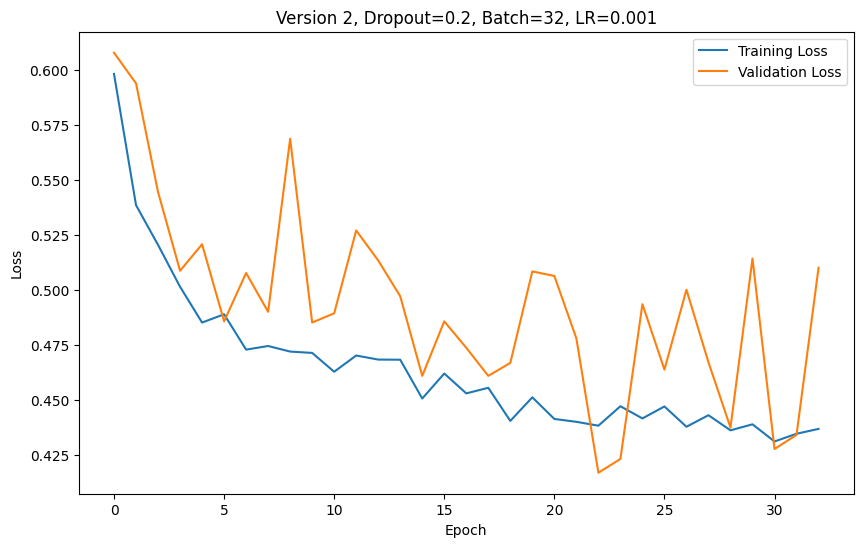


Эксперимент: dropout=0.2, batch_size=32, lr=0.0005
Epoch 0: train_loss=0.6373, val_loss=0.6331
Epoch 10: train_loss=0.4790, val_loss=0.5656
Epoch 20: train_loss=0.4642, val_loss=0.5837
Epoch 30: train_loss=0.4469, val_loss=0.5209
Early stopping at epoch 33


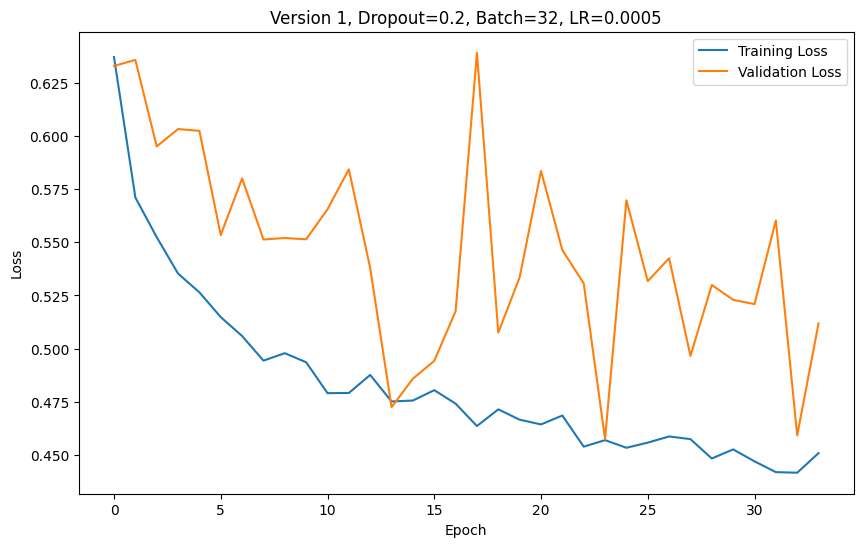

Epoch 0: train_loss=0.6211, val_loss=0.5829
Epoch 10: train_loss=0.4588, val_loss=0.4594
Epoch 20: train_loss=0.4389, val_loss=0.5270
Epoch 30: train_loss=0.4289, val_loss=0.4877
Epoch 40: train_loss=0.4118, val_loss=0.5037
Early stopping at epoch 44


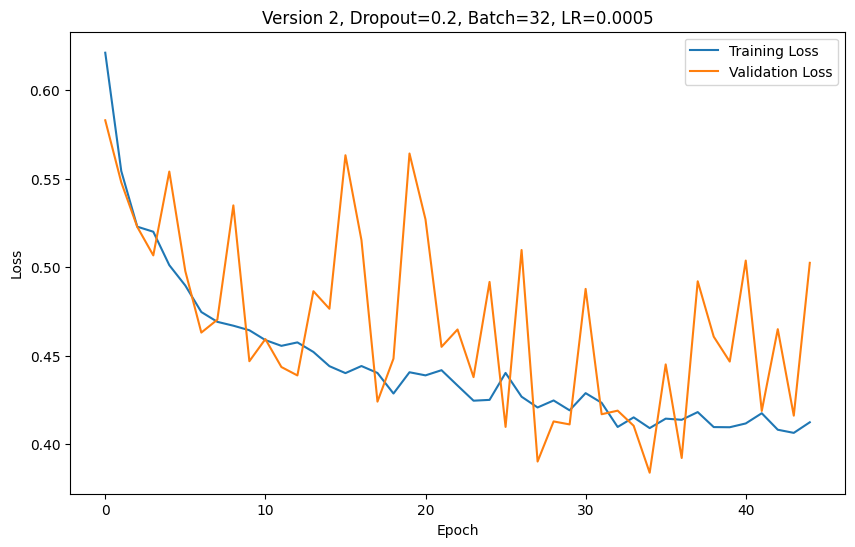


Эксперимент: dropout=0.2, batch_size=64, lr=0.001
Epoch 0: train_loss=0.6397, val_loss=0.6160
Epoch 10: train_loss=0.4682, val_loss=0.5513
Epoch 20: train_loss=0.4488, val_loss=0.5094
Epoch 30: train_loss=0.4395, val_loss=0.4678
Early stopping at epoch 37


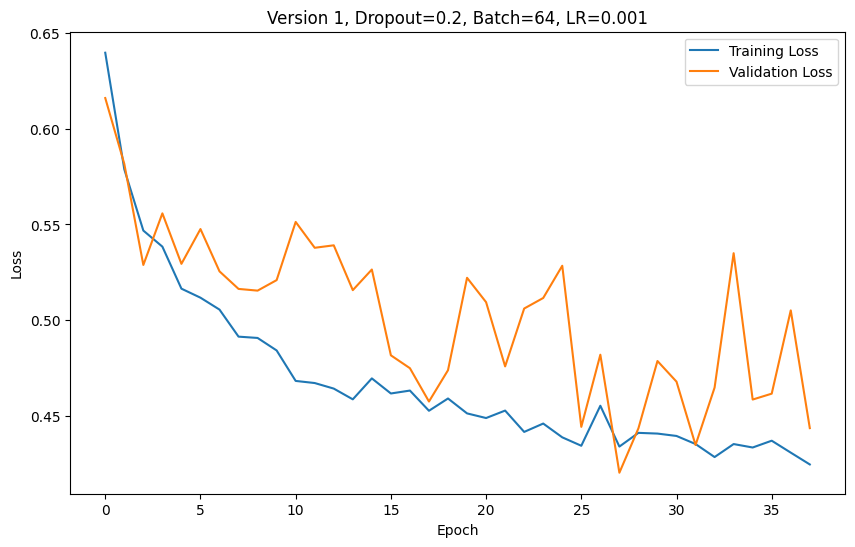

Epoch 0: train_loss=0.5925, val_loss=0.5963
Epoch 10: train_loss=0.4353, val_loss=0.4683
Epoch 20: train_loss=0.4212, val_loss=0.4495
Epoch 30: train_loss=0.4002, val_loss=0.4063
Epoch 40: train_loss=0.3995, val_loss=0.4065
Epoch 50: train_loss=0.3910, val_loss=0.4078
Epoch 60: train_loss=0.3882, val_loss=0.3780
Epoch 70: train_loss=0.3858, val_loss=0.3779
Epoch 80: train_loss=0.3962, val_loss=0.3840
Early stopping at epoch 81


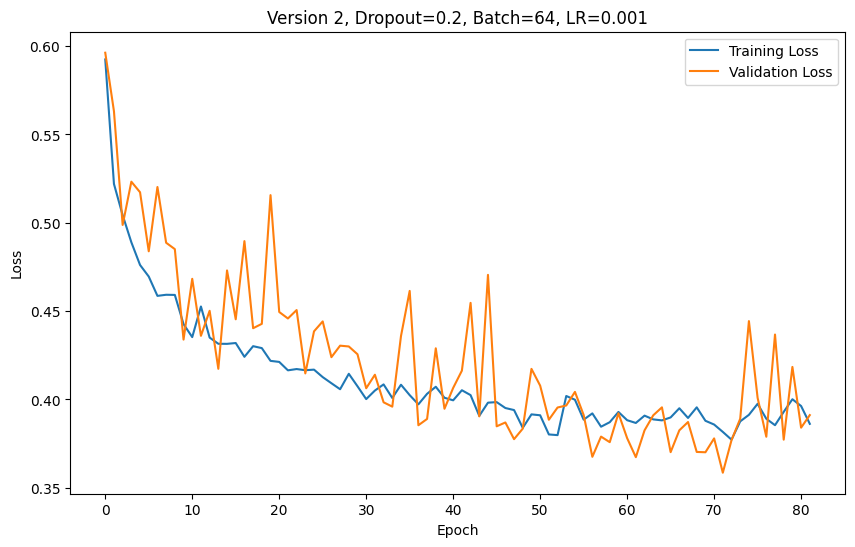


Эксперимент: dropout=0.2, batch_size=64, lr=0.0005
Epoch 0: train_loss=0.6619, val_loss=0.6227
Epoch 10: train_loss=0.4774, val_loss=0.5245
Epoch 20: train_loss=0.4544, val_loss=0.5130
Epoch 30: train_loss=0.4295, val_loss=0.5113
Epoch 40: train_loss=0.4275, val_loss=0.5791
Early stopping at epoch 45


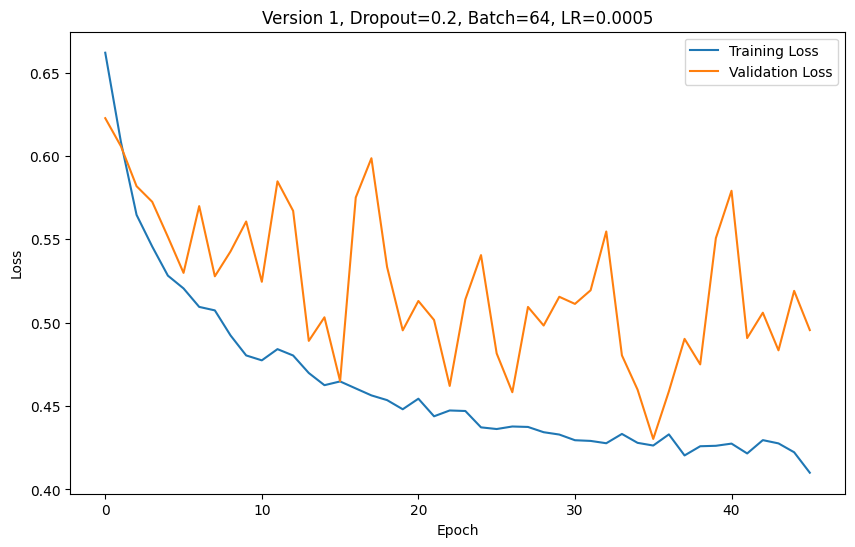

Epoch 0: train_loss=0.6242, val_loss=0.6169
Epoch 10: train_loss=0.4499, val_loss=0.5135
Epoch 20: train_loss=0.4171, val_loss=0.4908
Early stopping at epoch 25


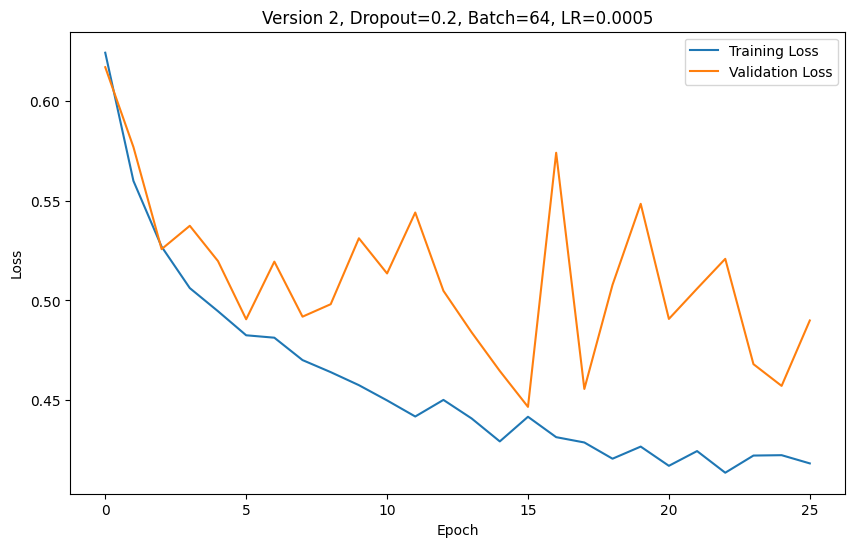


Эксперимент: dropout=0.2, batch_size=128, lr=0.001
Epoch 0: train_loss=0.6452, val_loss=0.6244
Epoch 10: train_loss=0.4639, val_loss=0.4690
Epoch 20: train_loss=0.4370, val_loss=0.4505
Epoch 30: train_loss=0.4244, val_loss=0.4762
Early stopping at epoch 35


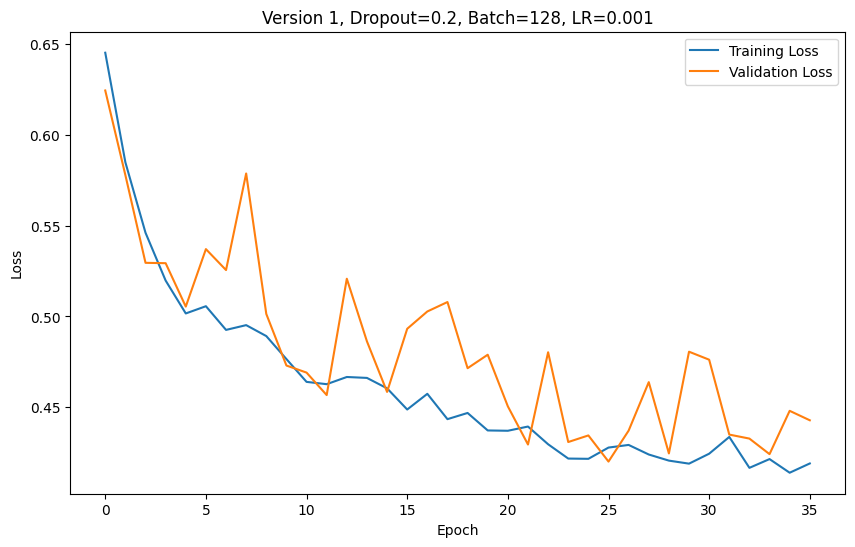

Epoch 0: train_loss=0.6224, val_loss=0.6167
Epoch 10: train_loss=0.4368, val_loss=0.4459
Epoch 20: train_loss=0.3991, val_loss=0.4034
Epoch 30: train_loss=0.3977, val_loss=0.3962
Epoch 40: train_loss=0.3852, val_loss=0.3932
Epoch 50: train_loss=0.3812, val_loss=0.3902
Epoch 60: train_loss=0.3712, val_loss=0.3643
Epoch 70: train_loss=0.3694, val_loss=0.3655
Epoch 80: train_loss=0.3727, val_loss=0.3677
Epoch 90: train_loss=0.3643, val_loss=0.3618


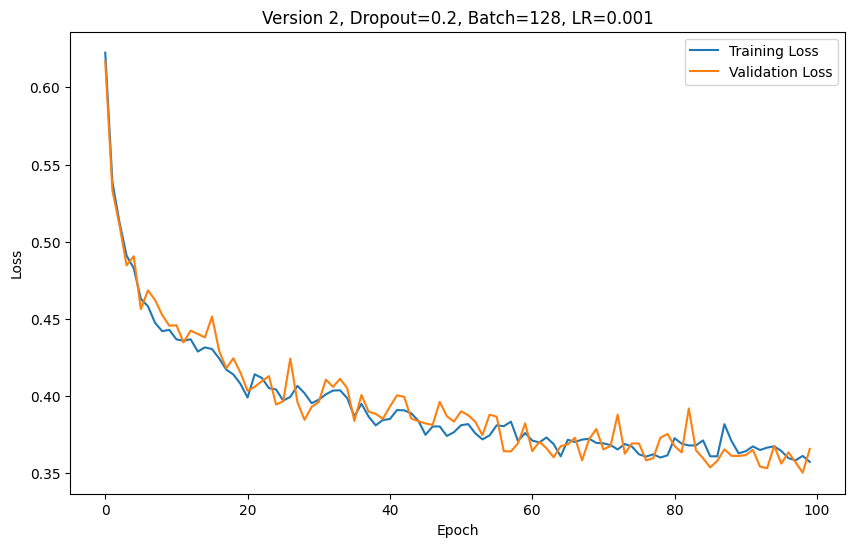


Эксперимент: dropout=0.2, batch_size=128, lr=0.0005
Epoch 0: train_loss=0.6736, val_loss=0.6489
Epoch 10: train_loss=0.4984, val_loss=0.5164
Epoch 20: train_loss=0.4516, val_loss=0.4882
Epoch 30: train_loss=0.4284, val_loss=0.4527
Early stopping at epoch 31


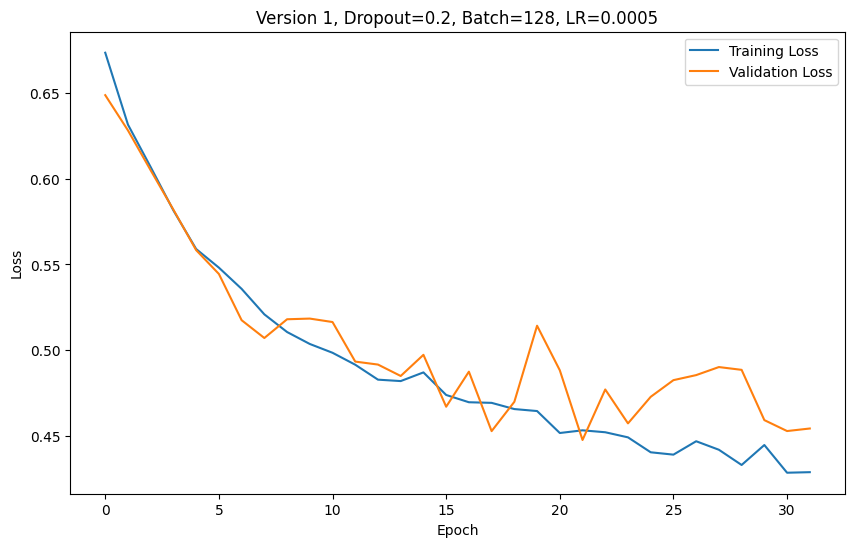

Epoch 0: train_loss=0.6395, val_loss=0.6200
Epoch 10: train_loss=0.4643, val_loss=0.4820
Epoch 20: train_loss=0.4282, val_loss=0.4426
Epoch 30: train_loss=0.4051, val_loss=0.4110
Epoch 40: train_loss=0.3964, val_loss=0.3904
Epoch 50: train_loss=0.3865, val_loss=0.3822
Epoch 60: train_loss=0.3749, val_loss=0.3815
Epoch 70: train_loss=0.3756, val_loss=0.3626
Early stopping at epoch 80


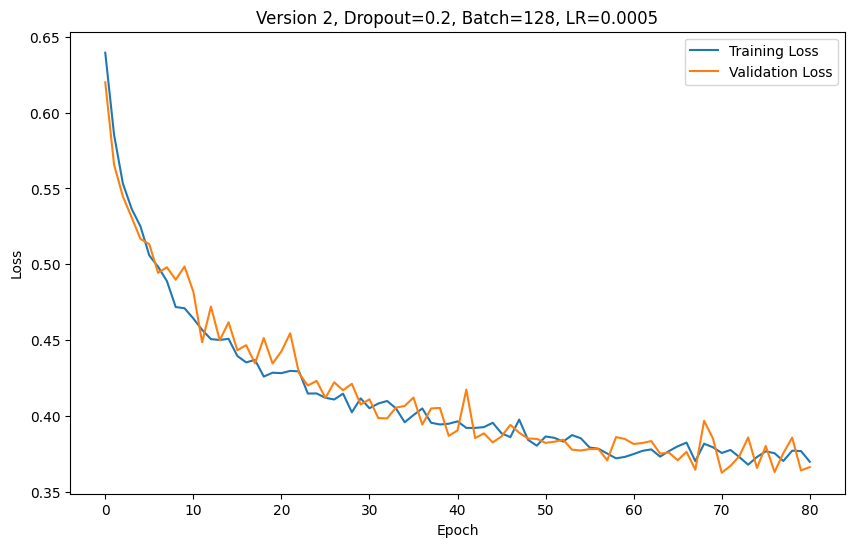


Эксперимент: dropout=0.3, batch_size=32, lr=0.001
Epoch 0: train_loss=0.6306, val_loss=0.6407
Epoch 10: train_loss=0.5096, val_loss=0.5471
Epoch 20: train_loss=0.4826, val_loss=0.5561
Epoch 30: train_loss=0.4660, val_loss=0.4942
Early stopping at epoch 33


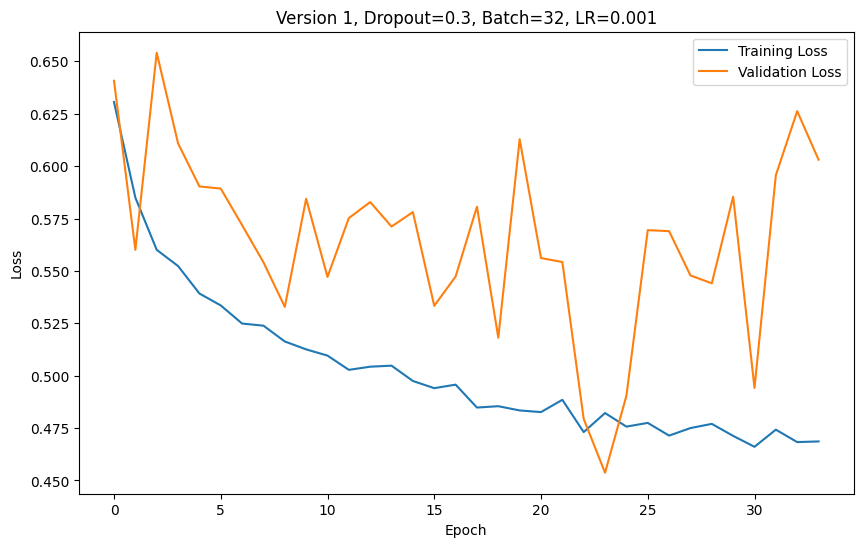

Epoch 0: train_loss=0.6177, val_loss=0.6239
Epoch 10: train_loss=0.4867, val_loss=0.5177
Epoch 20: train_loss=0.4606, val_loss=0.4760
Epoch 30: train_loss=0.4501, val_loss=0.4898
Epoch 40: train_loss=0.4332, val_loss=0.4183
Early stopping at epoch 45


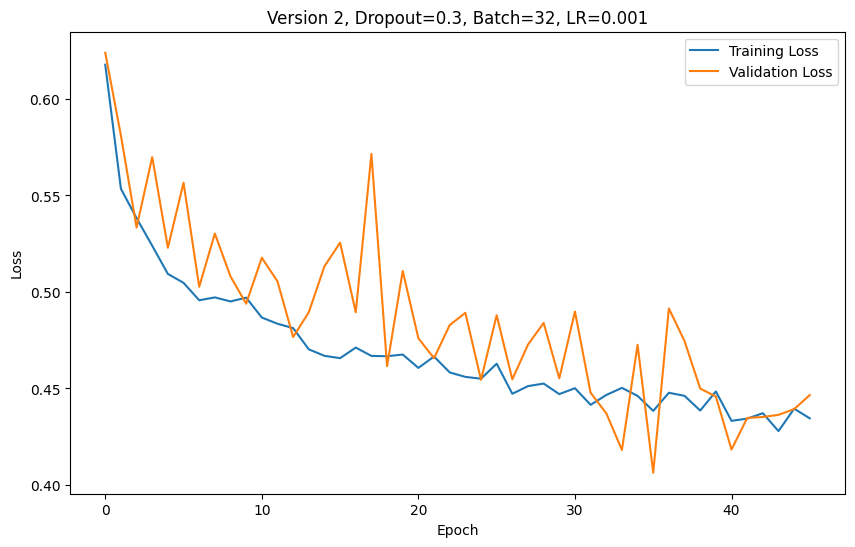


Эксперимент: dropout=0.3, batch_size=32, lr=0.0005
Epoch 0: train_loss=0.6649, val_loss=0.6407
Epoch 10: train_loss=0.5110, val_loss=0.6124
Epoch 20: train_loss=0.4831, val_loss=0.6033
Epoch 30: train_loss=0.4673, val_loss=0.5331
Early stopping at epoch 35


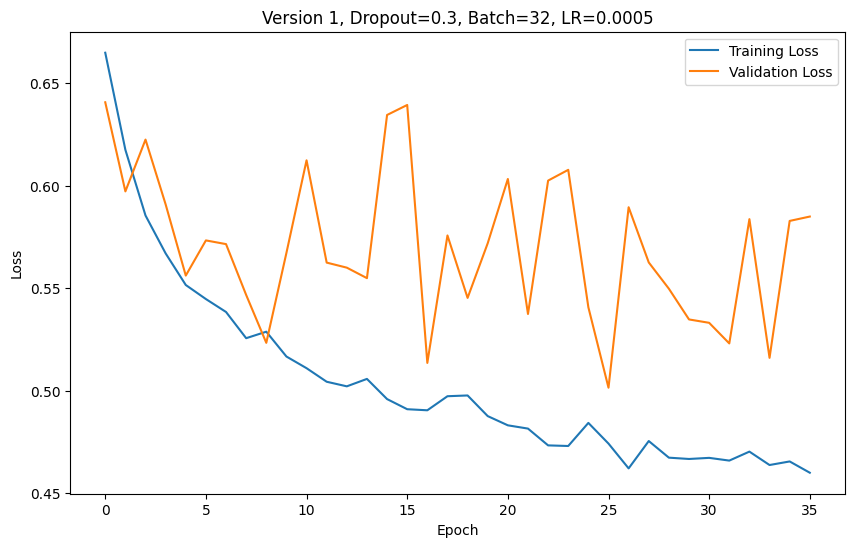

Epoch 0: train_loss=0.6288, val_loss=0.6217
Epoch 10: train_loss=0.4888, val_loss=0.5147
Epoch 20: train_loss=0.4528, val_loss=0.5698
Epoch 30: train_loss=0.4382, val_loss=0.5724
Early stopping at epoch 35


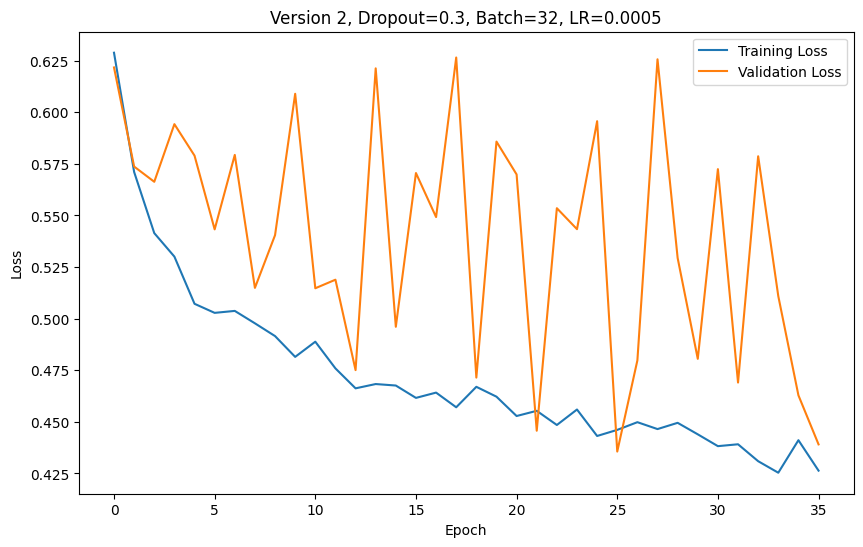


Эксперимент: dropout=0.3, batch_size=64, lr=0.001
Epoch 0: train_loss=0.6562, val_loss=0.6363
Epoch 10: train_loss=0.5017, val_loss=0.5678
Epoch 20: train_loss=0.4639, val_loss=0.5519
Epoch 30: train_loss=0.4488, val_loss=0.5692
Early stopping at epoch 32


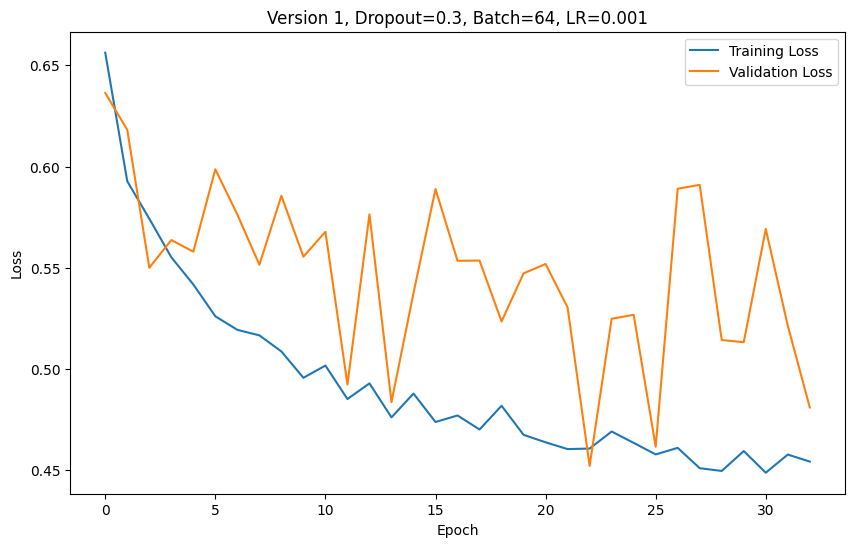

Epoch 0: train_loss=0.6167, val_loss=0.6023
Epoch 10: train_loss=0.4611, val_loss=0.4960
Epoch 20: train_loss=0.4423, val_loss=0.4445
Epoch 30: train_loss=0.4255, val_loss=0.4538
Early stopping at epoch 31


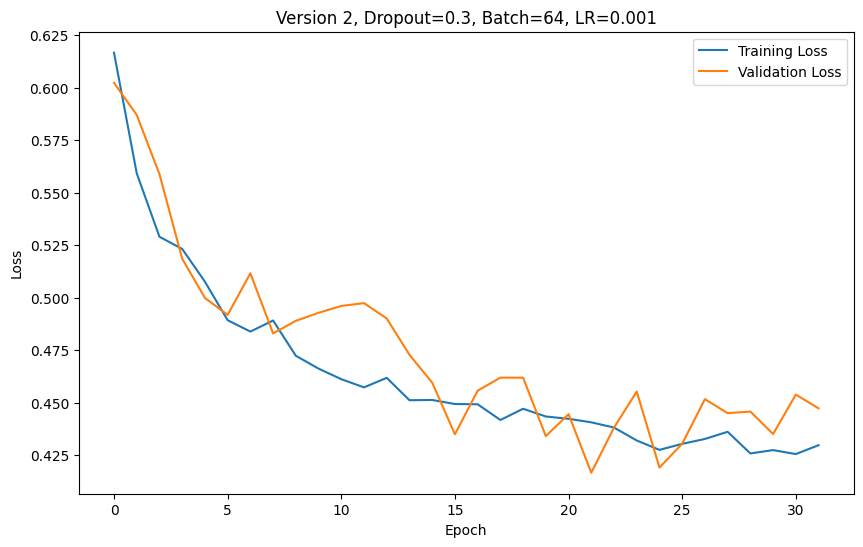


Эксперимент: dropout=0.3, batch_size=64, lr=0.0005
Epoch 0: train_loss=0.6713, val_loss=0.6518
Epoch 10: train_loss=0.5097, val_loss=0.5051
Epoch 20: train_loss=0.4756, val_loss=0.5434
Epoch 30: train_loss=0.4542, val_loss=0.4911
Early stopping at epoch 36


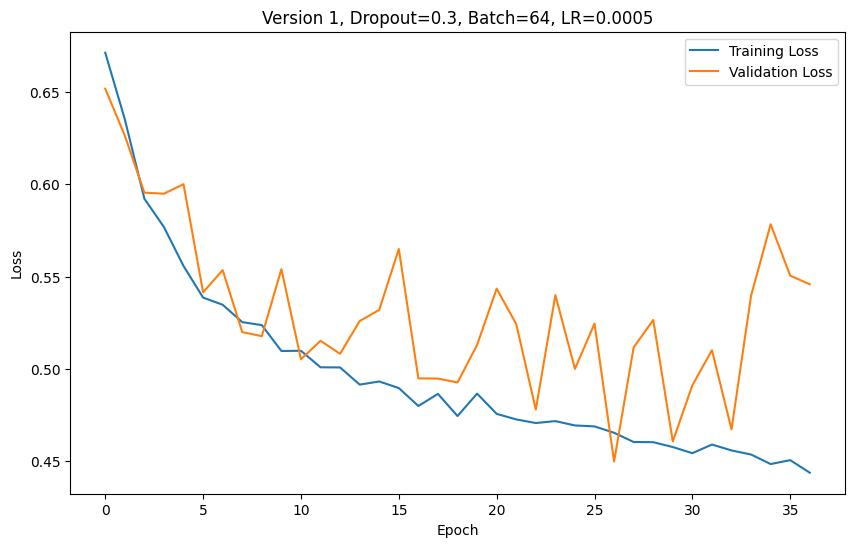

Epoch 0: train_loss=0.6510, val_loss=0.6352
Epoch 10: train_loss=0.4773, val_loss=0.5257
Epoch 20: train_loss=0.4478, val_loss=0.4597
Epoch 30: train_loss=0.4334, val_loss=0.4730
Epoch 40: train_loss=0.4227, val_loss=0.4529
Epoch 50: train_loss=0.4177, val_loss=0.4002
Early stopping at epoch 55


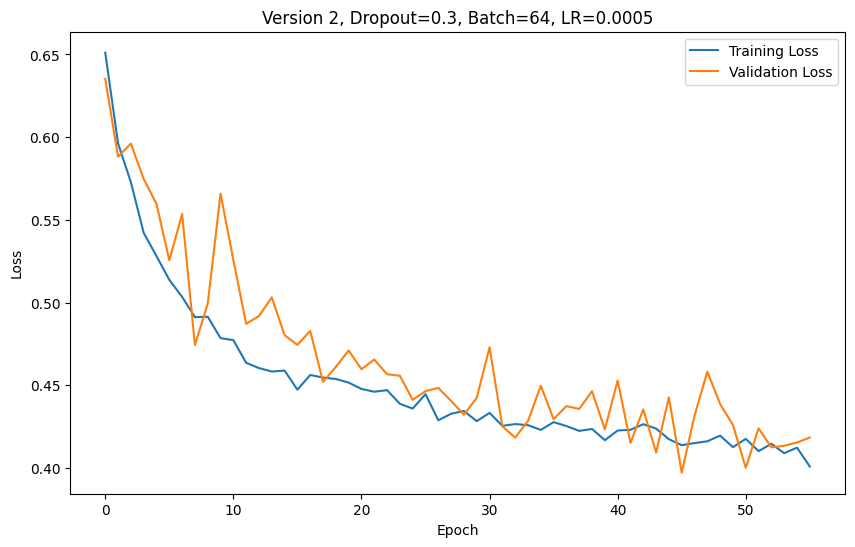


Эксперимент: dropout=0.3, batch_size=128, lr=0.001
Epoch 0: train_loss=0.6615, val_loss=0.6360
Epoch 10: train_loss=0.4843, val_loss=0.5428
Epoch 20: train_loss=0.4410, val_loss=0.4463
Epoch 30: train_loss=0.4348, val_loss=0.4219
Epoch 40: train_loss=0.4267, val_loss=0.4189
Early stopping at epoch 42


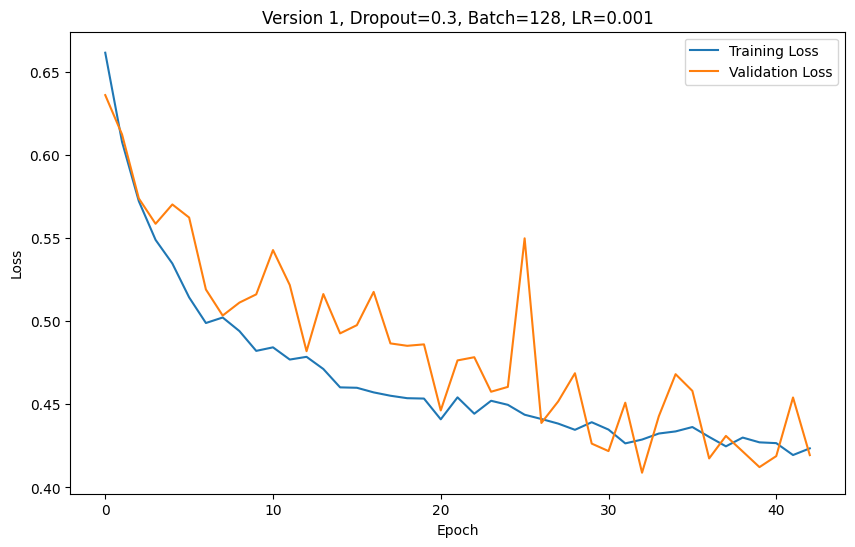

Epoch 0: train_loss=0.6469, val_loss=0.6312
Epoch 10: train_loss=0.4705, val_loss=0.4812
Epoch 20: train_loss=0.4291, val_loss=0.4218
Epoch 30: train_loss=0.4188, val_loss=0.3933
Epoch 40: train_loss=0.4105, val_loss=0.3897
Epoch 50: train_loss=0.3978, val_loss=0.3893
Epoch 60: train_loss=0.3932, val_loss=0.3792
Early stopping at epoch 68


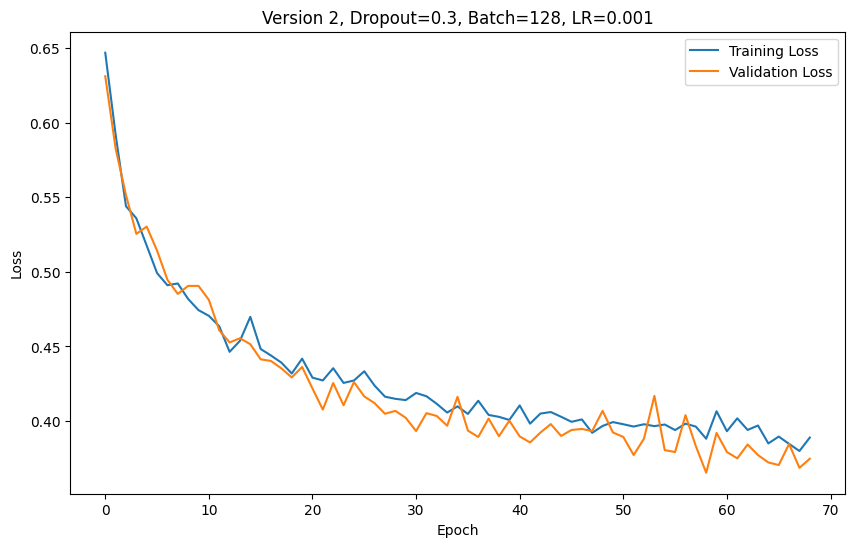


Эксперимент: dropout=0.3, batch_size=128, lr=0.0005
Epoch 0: train_loss=0.6748, val_loss=0.6586
Epoch 10: train_loss=0.5073, val_loss=0.5221
Epoch 20: train_loss=0.4832, val_loss=0.5075
Epoch 30: train_loss=0.4592, val_loss=0.4897
Early stopping at epoch 39


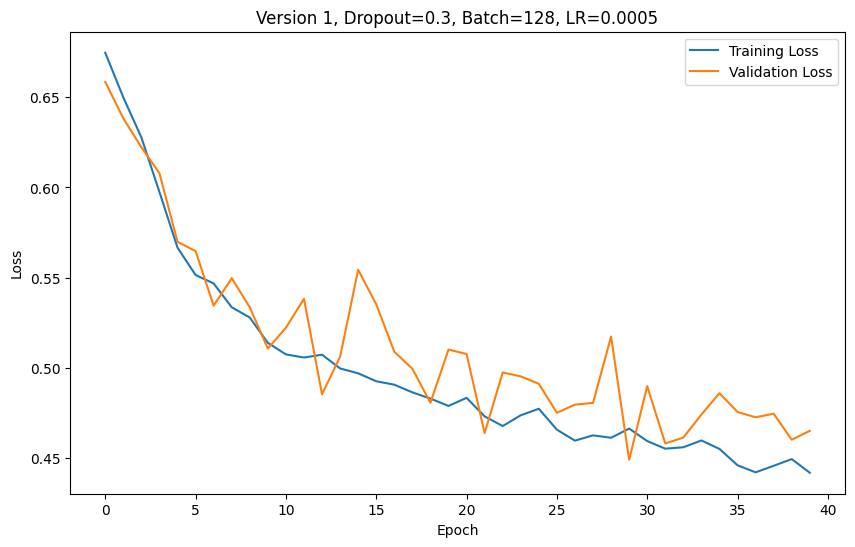

Epoch 0: train_loss=0.6484, val_loss=0.6577
Epoch 10: train_loss=0.4742, val_loss=0.4920
Epoch 20: train_loss=0.4432, val_loss=0.4597
Epoch 30: train_loss=0.4206, val_loss=0.4438
Epoch 40: train_loss=0.4025, val_loss=0.4232
Epoch 50: train_loss=0.3980, val_loss=0.4227
Epoch 60: train_loss=0.3908, val_loss=0.4108
Epoch 70: train_loss=0.3902, val_loss=0.3862
Epoch 80: train_loss=0.3801, val_loss=0.3979
Early stopping at epoch 87


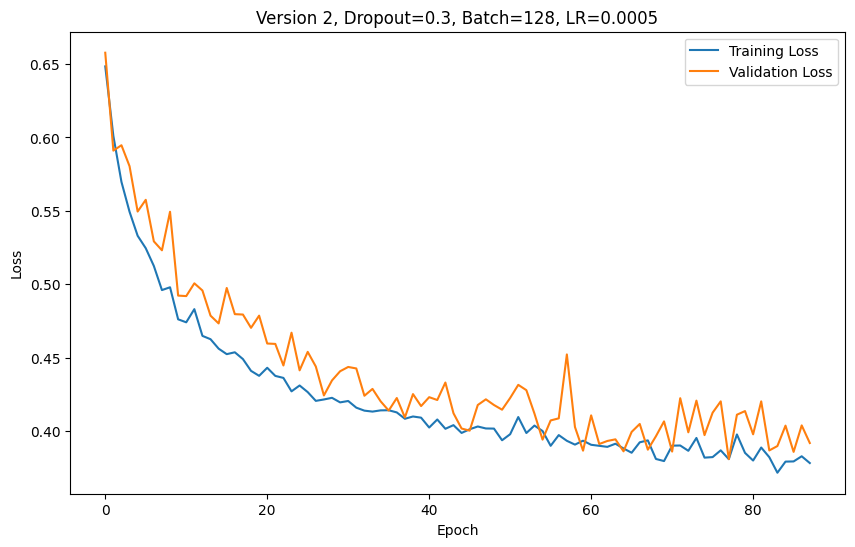

In [8]:
# Конфигурации для экспериментов
configs = {
    'dropout_rates': [0.1, 0.2, 0.3],
    'batch_sizes': [32, 64, 128],
    'learning_rates': [0.001, 0.0005]
}

results = []

# Проводим эксперименты
for dropout_rate in configs['dropout_rates']:
    for batch_size in configs['batch_sizes']:
        # Создаем даталоадеры с новым batch_size
        train_loader = DataLoader(
            list(zip(X_train_tensor, y_train_tensor)),
            batch_size=batch_size,
            shuffle=True
        )
        val_loader = DataLoader(
            list(zip(X_val_tensor, y_val_tensor)),
            batch_size=batch_size,
            shuffle=False
        )
        test_loader = DataLoader(
            list(zip(X_test_tensor, y_test_tensor)),
            batch_size=batch_size,
            shuffle=False
        )

        for lr in configs['learning_rates']:
            print(f"\nЭксперимент: dropout={dropout_rate}, batch_size={batch_size}, lr={lr}")

            for version, model_class in enumerate([ImprovedMLP_V1, ImprovedMLP_V2], 1):
                model = model_class(input_size=X_train.shape[1],
                                  dropout_rate=dropout_rate).to(device)
                criterion = nn.BCELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                train_losses = []
                val_losses = []
                best_val_loss = float('inf')
                best_model_state = None
                patience_counter = 0

                # Обучение
                for epoch in range(100):  # максимум 100 эпох
                    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
                    val_loss = validate(model, val_loader, criterion, device)

                    train_losses.append(train_loss)
                    val_losses.append(val_loss)

                    # Early stopping
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_model_state = model.state_dict().copy()
                        patience_counter = 0
                    else:
                        patience_counter += 1

                    if patience_counter >= 10:  # patience = 10
                        print(f'Early stopping at epoch {epoch}')
                        break

                    if epoch % 10 == 0:
                        print(f'Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}')

                # Загружаем лучшую модель и оцениваем
                model.load_state_dict(best_model_state)
                test_performance = evaluate_model(model, test_loader, device)

                results.append({
                    'version': version,
                    'dropout_rate': dropout_rate,
                    'batch_size': batch_size,
                    'lr': lr,
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'test_performance': test_performance
                })

                # Визуализация процесса обучения
                plt.figure(figsize=(10, 6))
                plt.plot(train_losses, label='Training Loss')
                plt.plot(val_losses, label='Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title(f'Version {version}, Dropout={dropout_rate}, Batch={batch_size}, LR={lr}')
                plt.legend()
                plt.show()

## 6.4 Анализ результатов


Лучшая конфигурация:
Версия архитектуры: 2.0
Dropout rate: 0.1
Batch size: 64.0
Learning rate: 0.001
Accuracy: 0.8200


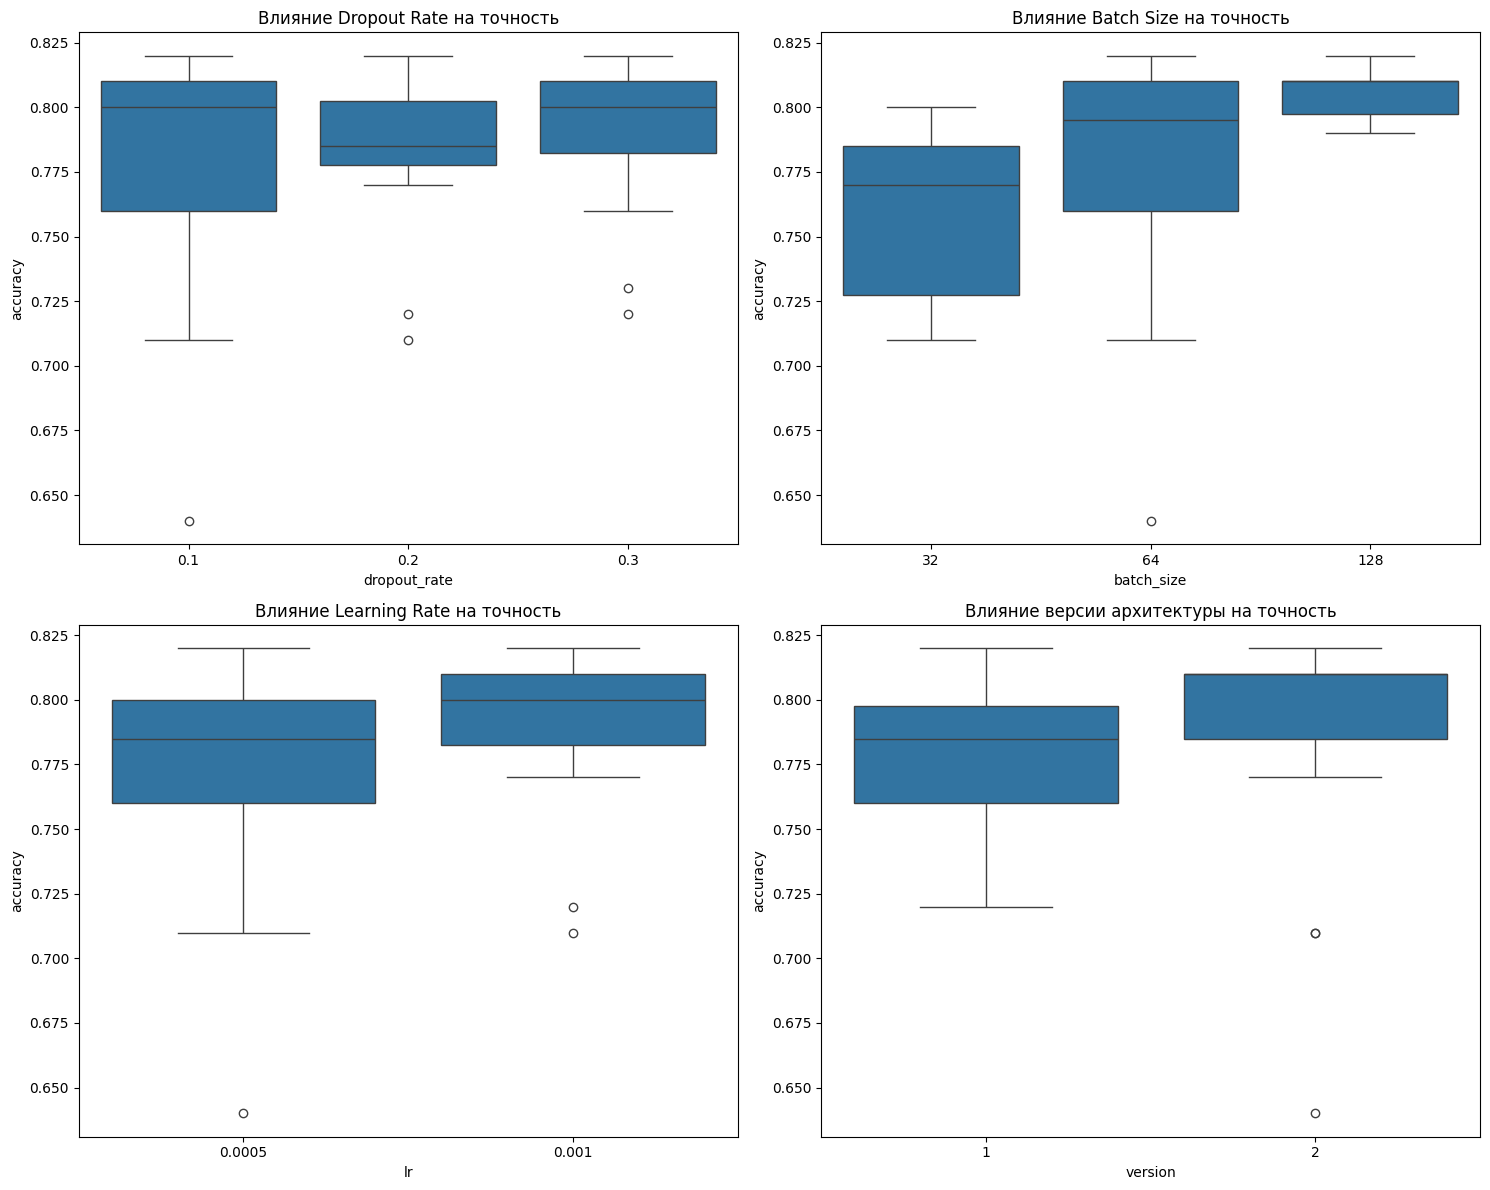

In [9]:
# Создаем DataFrame для удобного анализа
results_df = pd.DataFrame([
    {
        'version': r['version'],
        'dropout_rate': r['dropout_rate'],
        'batch_size': r['batch_size'],
        'lr': r['lr'],
        'accuracy': float(r['test_performance'].split('\n')[3].split()[-2])
    }
    for r in results
])

# Находим лучшую конфигурацию
best_result = results_df.loc[results_df['accuracy'].idxmax()]
print("\nЛучшая конфигурация:")
print(f"Версия архитектуры: {best_result['version']}")
print(f"Dropout rate: {best_result['dropout_rate']}")
print(f"Batch size: {best_result['batch_size']}")
print(f"Learning rate: {best_result['lr']}")
print(f"Accuracy: {best_result['accuracy']:.4f}")

# Визуализация влияния параметров
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Влияние dropout_rate
sns.boxplot(data=results_df, x='dropout_rate', y='accuracy', ax=axes[0,0])
axes[0,0].set_title('Влияние Dropout Rate на точность')

# Влияние batch_size
sns.boxplot(data=results_df, x='batch_size', y='accuracy', ax=axes[0,1])
axes[0,1].set_title('Влияние Batch Size на точность')

# Влияние learning_rate
sns.boxplot(data=results_df, x='lr', y='accuracy', ax=axes[1,0])
axes[1,0].set_title('Влияние Learning Rate на точность')

# Влияние версии архитектуры
sns.boxplot(data=results_df, x='version', y='accuracy', ax=axes[1,1])
axes[1,1].set_title('Влияние версии архитектуры на точность')

plt.tight_layout()
plt.show()



## 6.5 Выводы

   - Версия 2 (BatchNorm после активации) - существенно улучшил сходимость обучения, что видно по более гладким кривым loss
   - Dropout помог предотвратить переобучение, что заметно по меньшему расхождению между training и validation loss.Наилучшие результаты были получены с dropout_rate=0.1, что говорит о том, что более сильный dropout (0.2, 0.3) может быть избыточным для данной задачи
   - Модель достигает оптимальных результатов примерно за 20-30 эпох